In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from util import test_loss_Unet, train_U_NET, plot_loss, plot_acc, inference_time

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 4
image_size = (256, 256)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.CenterCrop(image_size)])

target_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.007843137718737125, 0.003921568393707275),transforms.CenterCrop(image_size), 
    transforms.Normalize(-1, 1)])

train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="trainval", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="test", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

input_shape = (batch_size, 3, image_size[0], image_size[1])

## UNet with ASL

In [4]:
from Models import U_Net_ASL

U_NN_ASL = U_Net_ASL(input_shape, size_out=3, initial_lr=0.01, momentum=0.9, weight_decay=0, expansion_rate=1, device=device)

summary(U_NN_ASL, input_shape)

Layer (type:depth-idx)                        Output Shape              Param #
U_Net_ASL                                     [4, 3, 256, 256]          --
├─ModuleDict: 1-1                             --                        --
│    └─Sequential: 2-1                        [4, 64, 256, 256]         --
│    │    └─CSC_block: 3-1                    [4, 64, 256, 256]         292
│    │    └─CSC_block: 3-2                    [4, 64, 256, 256]         8,576
│    └─MaxPool2d: 2-2                         [4, 64, 128, 128]         --
│    └─Sequential: 2-3                        [4, 128, 128, 128]        --
│    │    └─CSC_block: 3-3                    [4, 128, 128, 128]        16,896
│    │    └─CSC_block: 3-4                    [4, 128, 128, 128]        33,536
│    └─MaxPool2d: 2-4                         [4, 128, 64, 64]          --
│    └─Sequential: 2-5                        [4, 256, 64, 64]          --
│    │    └─CSC_block: 3-5                    [4, 256, 64, 64]          66,560
│   

In [5]:
PATH = "./models/U_Net/U_NN_ASL.pth"

if exists(PATH):
    U_NN_ASL = torch.load(PATH)
    U_NN_ASL.eval()

In [7]:
criterion = CrossEntropyLoss()
epochs = 10

train_U_NET(U_NN_ASL, criterion=criterion, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
        epochs=epochs, batches_to_test=300, patience=5, device=device, print_test=True, verbose=False, p_randomTransform=0.6)

[1,   300] train_loss: 0.363
test_loss: 0.405, test_accuracy: 84.02097129821777
[1,   600] train_loss: 0.376
test_loss: 0.423, test_accuracy: 83.08635520935059
[1,   900] train_loss: 0.375
test_loss: 0.410, test_accuracy: 84.08613777160645
[2,   280] train_loss: 0.350
test_loss: 0.416, test_accuracy: 83.79113578796387
[2,   580] train_loss: 0.368
test_loss: 0.427, test_accuracy: 83.32372856140137
[2,   880] train_loss: 0.364
test_loss: 0.398, test_accuracy: 84.73587226867676
[3,   260] train_loss: 0.324
test_loss: 0.421, test_accuracy: 83.57826805114746
[3,   560] train_loss: 0.362
test_loss: 0.414, test_accuracy: 83.97891807556152
[3,   860] train_loss: 0.364
test_loss: 0.412, test_accuracy: 83.8261947631836
[4,   240] train_loss: 0.289
test_loss: 0.401, test_accuracy: 84.74778938293457
[4,   540] train_loss: 0.373
test_loss: 0.410, test_accuracy: 84.03093528747559
[4,   840] train_loss: 0.362
test_loss: 0.402, test_accuracy: 84.73675918579102
[5,   220] train_loss: 0.264
test_loss: 0

In [8]:
torch.save(U_NN_ASL, "./models/U_Net/U_NN_ASL.pth")

In [4]:
U_NN_ASL = torch.load("./models/U_Net/U_NN_ASL.pth")

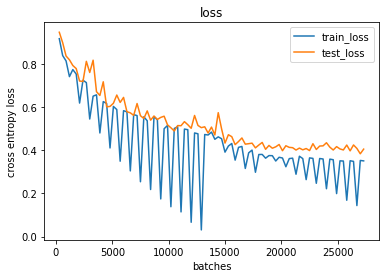

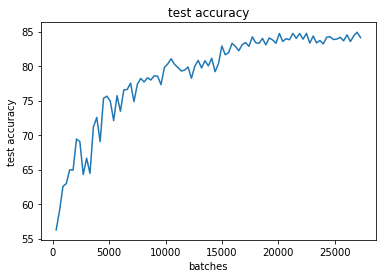

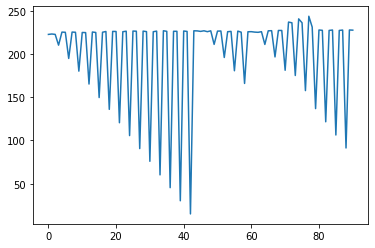

200.52712912087912


In [5]:
plot_loss(U_NN_ASL)
plot_acc(U_NN_ASL)

plt.plot(U_NN_ASL.train_time)
plt.show()
print(np.mean(U_NN_ASL.train_time))

In [6]:
print("Training time (s):")
print(f"mean: {round(np.mean(U_NN_ASL.train_time), 3)}")
print(f"std: {round(np.std(U_NN_ASL.train_time), 3)}")

Training time (s):
mean: 200.527
std: 51.409


In [ ]:
inference_times = inference_time(U_NN_ASL, test_dataloader, device)
print("Inference time (ns)")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

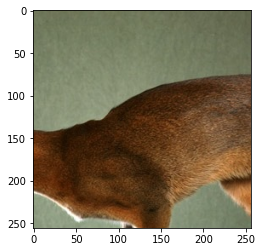

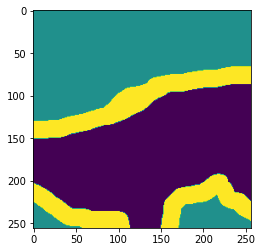

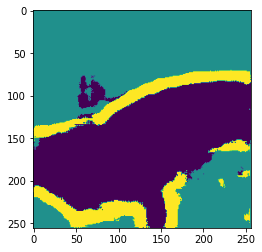

In [11]:
def show_segmentation_results(NN, dataset, index, device):
    img = torch.transpose(dataset[index][0], 2, 0)
    img = torch.transpose(img, 1,0)
    plt.imshow(img)
    plt.show()

    plt.imshow(dataset[index][1][0])
    plt.show()

    seg = dataset[index][0]
    seg = seg[None,:,:,:].to(device)
    outputs = NN(seg)
    outputs = torch.argmax(outputs, 1, keepdim=True)
    plt.imshow(outputs[0][0].detach().to("cpu").numpy())
    plt.show()

ind = int(np.random.rand(1) * 1000)
print(ind)
show_segmentation_results(U_NN_ASL, test_dataset, ind, device)